In [69]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import f1_score, precision_score, confusion_matrix, accuracy_score, recall_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder
import datetime
import os
import csv
import math
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick


pd.set_option('display.max_rows', 100)

In [70]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputAlgorithmsFolder = inputFolder + r"\algorithms"
inputUnderstandingFolder = inputFolder + r"\join"

outputAllFolder = outputFolder + r"\all"
outputSummaryFolder = outputFolder + r"\summary"
outputReportsFolder = outputFolder + r"\reports"

resultsFolder = "../results/1-input/2-posttest/"

dataVisualizationTopLimit = 20

testSize = 0.25
genericRandomState = 0
splitRandomState = 0
samplingStrategy = 0.25
percentileNumberStd = 90
percentileNumberCorrelation = 90

iterationsNumber = 3
splitsNumber = 4

In [71]:
classifiers = {
  "K vecinos más cercanos": { "name": "K vecinos más cercanos", "acronym": "KNN", "classifier": KNeighborsClassifier(weights="uniform", algorithm="ball_tree", p=1) }, 
  "Máquina de vectores de soporte": { "name": "Máquina de vectores de soporte", "acronym": "SVM", "classifier": SVC(random_state=genericRandomState) }, 
  "Regresión logística": { "name": "Regresión logística", "acronym": "LR", "classifier": LogisticRegression(random_state=genericRandomState, max_iter=200, solver="saga") }, 
  "Árbol de decisión": { "name": "Árbol de decisión", "acronym": "DT", "classifier": DecisionTreeClassifier(random_state=genericRandomState, criterion="gini", splitter="best", max_depth=200 ) }, 
  "Bosque aleatorio": { "name": "Bosque aleatorio", "acronym": "RF", "classifier": RandomForestClassifier(random_state=genericRandomState) }, 
  "Aumento de gradiente": { "name": "Aumento de gradiente", "acronym": "GBM", "classifier": GradientBoostingClassifier(random_state=genericRandomState, n_estimators=200) }, 
}

In [72]:
crossValidators = {
  "K pliegues": { "name": "K pliegues", "acronym": "KP", "validator": KFold(n_splits=splitsNumber, shuffle=True, random_state=genericRandomState) }, 
  "K pliegues estratificados": { "name": "K pliegues estratificados", "acronym": "KPE", "validator": StratifiedKFold(n_splits=splitsNumber, shuffle=True, random_state=genericRandomState) }, 
  "División aleatoria": { "name": "División aleatoria", "acronym": "DA", "validator": ShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=genericRandomState) }, 
  "División aleatoria estratificada": { "name": "División aleatoria estratificada", "acronym": "DAE", "validator": StratifiedShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=genericRandomState) }, 
}

In [73]:
def getCrossValidators(randomState):
  return {
    "K pliegues": { "name": "K pliegues", "acronym": "KP", "validator": KFold(n_splits=splitsNumber, shuffle=True, random_state=randomState) }, 
    "K pliegues estratificados": { "name": "K pliegues estratificados", "acronym": "KPE", "validator": StratifiedKFold(n_splits=splitsNumber, shuffle=True, random_state=randomState) }, 
    "División aleatoria": { "name": "División aleatoria", "acronym": "DA", "validator": ShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=randomState) }, 
    "División aleatoria estratificada": { "name": "División aleatoria estratificada", "acronym": "DAE", "validator": StratifiedShuffleSplit(n_splits=splitsNumber, test_size=testSize, random_state=randomState) }, 
  }

In [74]:
# Funciones utilitarias de archivos
def readCsvAsDict(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  data = df.to_dict('records')
  return data

def readCsvAsDf(filePath, delimiter=",", encoding="utf-8", header=0, dtype={}):
  df = pd.read_csv(filePath, delimiter=delimiter,encoding=encoding, header=header, dtype=dtype)
  df = df.replace(np.nan, '', regex=True)
  return df

def writeDictToCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeDfToCsv(data, pathCsv, encoding='utf-8', header=True):
  data.to_csv(path_or_buf = pathCsv, encoding = encoding, header=header, index=False)

def parseTranspose(df):
  transposedDf = df.transpose()
  transposedDf = transposedDf.reset_index()
  transposedDf.columns = transposedDf.iloc[0]
  transposedDf = transposedDf[1:]

  return transposedDf

In [75]:
def showOversampling(df):
  colors = ["tab:blue", "tab:green"]
  topDf = df["contratado"].astype(str).value_counts().head(dataVisualizationTopLimit)
  print(topDf)
  classes = list(topDf.index)
  values = list(topDf.values)
  graph = plt.bar(classes, values, color=colors)

  percentage = []
  for value in values:
    pct = (value / sum(values)) * 100
    percentage.append(round(pct,2))

  for index, p in enumerate(graph):
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+width/2, y+height+50, str(percentage[index])+'%', ha='center', weight='bold')

  plt.xlabel("Contratado")
  plt.ylabel("Número de postulantes")
  plt.title("Número de postulantes contratados y no contratados")
  plt.show()

def showDifferentValues(df):
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  seriesDf = df.nunique().filter(items=categoricalCardinalColumns)
  resultDf = pd.DataFrame({'column': seriesDf.index, 'differentValuesNumber': seriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)
  
  display(resultDf)

def showMaxMinNumerical(df):
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  minSeriesDf = df.min().filter(items=numericalColumns)
  maxSeriesDf = df.max().filter(items=numericalColumns)
  resultDf = pd.DataFrame({'column': numericalColumns, 'minValue': minSeriesDf.values, 'maxValue': maxSeriesDf.values})
  resultDf.index = range(1,len(resultDf)+1)

  display(resultDf)

In [76]:
def showMetricsCharts(metricsList, context, unit):
  metrics = [
    {"exactitud": "Exactitud"},
    {"precision": "Precisión"},
    {"sensibilidad": "Sensibilidad"},
    {"robustez": "Robustez"},
    {"tiempoEntrenamientoModelo": "Tiempo de entrenamiento del modelo"},
    {"tiempoGeneracionReporte": "Tiempo de generación del reporte"},
    {"promedioMetricas": "Promedio de métricas"},
  ]

  for metric in metrics:
    key = list(metric.keys())[0]
    value = metric[key]

    data = {}
    for elem in metricsList:
      data["\n".join(elem[context].split(" "))] = float(elem[key])
    
    keys = list(data.keys())
    values = list(data.values())
      
    fig = plt.figure(figsize = (10, 5))

    if key == "tiempoEntrenamientoModelo":
      sortedValues = sorted(values, reverse=True)
      maxValue = sortedValues[len(sortedValues)-1]
      colors = ['tab:red' if (elem == maxValue) else 'tab:blue' for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.0f}s".format(x)))
      plt.ylabel("Segundos")
    elif key == "tiempoGeneracionReporte":
      sortedValues = sorted(values, reverse=True)
      maxValue = sortedValues[len(sortedValues)-1]
      colors = ['tab:red' if (elem == maxValue) else 'tab:blue' for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, y: "{:.2f}s".format(x)))
      plt.ylabel("Segundos")
    else:
      sortedValues = sorted(values)
      maxValue = sortedValues[len(sortedValues)-1]
      colors = ['tab:red' if (elem == maxValue) else 'tab:blue' for elem in values]
      plt.bar(keys, values, width = 0.4, color=colors)
      
      plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
      plt.ylabel("Porcentaje")
    
    plt.title("{} por {}".format(value, unit))
    plt.show()

In [77]:
def preprocessingData(inputPath):
  # Leyendo datos
  df = readCsvAsDf(inputPath)

  showOversampling(df)

  # Balanceo de datos: Sobremuestreo aleatorio (oversampling) (1 de cada 5)
  objectiveColumn = "contratado"

  # Obteniendo el número de repeticiones de cada clase
  dictResults = dict(df[objectiveColumn].value_counts().sort_index())

  # Obteniendo la clase con mas repeticiones y su valor
  maxKey = max(dictResults, key=dictResults.get)
  maxValue = max(dictResults.values())

  # Iterando por cada clase
  for key, value in dictResults.items():
    # Si no es la clase máxima
    if key != maxKey:
      # Se crea un temporal con solo filas con esa clase
      dfClass = df[df[objectiveColumn] == key]
      # Se crea el sobremuestreo adicional, es decir, las filas a agregar para que la proporción de sobremuestro se cumpla
      dfClassSampled = dfClass.sample(int(maxValue * samplingStrategy)-value, random_state=genericRandomState, replace=True)
      # Se agregan esas filas al dataframe principal
      df = pd.concat([df, dfClassSampled], axis=0)

  # Esto se hace para que el orden del indice inicial no se mezcle o cambie segun el sobremuestro

  # Reseteando el indice para que cada fila nuevamente sea unica
  df = df.reset_index(drop=True)

  showOversampling(df)

  # Aplicando OrdinalEncoding a las variables categóricas ordinales()
  encoder = OrdinalEncoder(categories=[[ "Abandonado", "En Curso", "Graduado" ]])
  encoder.fit(df[["estadoUltimoEstudio"]])
  df["estadoUltimoEstudio"] = encoder.transform(df[["estadoUltimoEstudio"]])
  encoder = OrdinalEncoder(categories=[[ "Otro", "Secundario", "Terciario/Tecnico", "Universitario", "Posgrado", "Master", "Doctorado" ]])
  encoder.fit(df[["gradoUltimoEstudio"]])
  df["gradoUltimoEstudio"] = encoder.transform(df[["gradoUltimoEstudio"]])

  showDifferentValues(df)
  
  # Aplicando OneHotEncoding a las variables categóricas cardinales (transformación a numéricas mediante columnas)
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "object" ]
  categoricalCardinalColumns = [columnName for columnName in categoricalColumns if columnName not in [ "estadoUltimoEstudio", "gradoUltimoEstudio" ]]

  for column in categoricalCardinalColumns:
    dummies = pd.get_dummies(df[[column]], prefix=column) # El dummy_na te genera una columna, asi tenga na's o no
    df = pd.concat([df, dummies], axis = 1)
    df = df.drop(columns=[column])

  showMaxMinNumerical(df)

  # Aplicando MinMaxScaler a las variables numéricas (normalización) (esto tambien incluye a lastEducationStatus y lastEducationDegree, ya numéricas)
  # Algunas quedaran en 0.9999, esto porque no todas manejan la misma escala (sin decimales, o solo un decimal)
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "contratado" ] and columnType == "float64" ]

  for column in numericalColumns:
    df[column] = df[column].fillna(0.0)
  mms = MinMaxScaler()
  df[numericalColumns] = mms.fit_transform(df[numericalColumns])

  print(len(df.columns))

  # Eliminando columnas con varianza cercana a cero, dejando el 10% de columnas con mayor varianza (variables no afectan en el resultado del modelo)
  df.loc['std'] = df.std()
  stdArray = df.iloc[len(df)-1]
  nthPercentileStd = np.percentile(stdArray, percentileNumberStd)
  print(nthPercentileStd)
  df = df.transpose()
  df = df[df["std"]>nthPercentileStd]
  df = df.transpose()
  df = df.drop(['std'], axis=0)

  print(len(df.columns))

  # Eliminando columnas con correlación cercana a uno, dejando el 90% de columnas con menor correlación
  correlationMatrix = df.corr().abs()
  correlationMatrix[correlationMatrix == 1.0] = 0.0
  maxCorrelationValues = [max(correlationMatrix[column]) for column in correlationMatrix.columns]
  nthPercentileCorrelation = np.percentile(maxCorrelationValues, percentileNumberCorrelation)
  print(nthPercentileCorrelation)
  highCorrelationColumns = [column for column in correlationMatrix.columns if max(correlationMatrix[column]) > nthPercentileCorrelation]
  df = df.drop(highCorrelationColumns, axis=1)
  
  print(len(df.columns))

  writeDfToCsv(df, os.path.join(processFolder, 'result.csv'))

  return df

In [78]:
def splitData(X, y):
  # Dividiendo los dataframes de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize, random_state=splitRandomState)

  return X_train, X_test, y_train, y_test

In [79]:
def trainModel(X_train, X_test, y_train, y_test, algorithm):
  # Creación del clasificador
  clf = classifiers[algorithm]["classifier"]

  # Entrenamiento del clasificador
  clf.fit(X_train, y_train)

  # Calculando la predicción del modelo con la data de prueba
  y_pred = clf.predict(X_test)

  return y_test, y_pred

In [80]:
def generateReport(y_pred, y_test, understandingDf, technique, iterationNumber, partitionNumber):
  # Pasando las predicciones a un dataframe
  yPredDf = pd.DataFrame(y_pred, index=y_test.index)
    
  # Haciendo un cruce entre la data inicial y las predicciones segun el indice
  joinDf = understandingDf.join(yPredDf, how="inner")

  # Eliminando la variable inicial y renombrando la variable objetivo
  joinDf = joinDf.drop(["contratado"], axis=1)
  joinDf = joinDf.rename(columns={0: "contratado"})

  # Escribiendo el reporte
  writeDfToCsv(joinDf, os.path.join(outputReportsFolder, "{}_{}_{}.csv".format(crossValidators[technique]["acronym"], iterationNumber, partitionNumber)))

In [81]:
def getMetrics(y_train, y_test, y_pred, trainingStartDate, trainingEndDate, generatingStartDate, generatingEndDate, algorithm, iterationNumber = None, technique = None, partitionNumber = None):
  trainRows = len(y_train)
  testRows = len(y_test)

  # Calculando la exactitud del modelo
  accuracy = accuracy_score(y_test, y_pred)

  # Calculando la precisión del modelo
  precision = precision_score(y_test, y_pred)

  # Calculando la sensibilidad del modelo
  recall = recall_score(y_test, y_pred)

  # Calculando el valor F del modelo (robustez)
  f1Score = f1_score(y_test, y_pred)

  # Calculando el promedio de métricas
  metricsList = [accuracy, precision, recall, f1Score]
  metricsMean = sum(metricsList) / len(metricsList)

  # Calculando el tiempo de ejecución del modelo
  trainingModelTime = (trainingEndDate - trainingStartDate).total_seconds()

  # Calculando el tiempo de generación del reporte
  generatingReportTime = (generatingEndDate - generatingStartDate).total_seconds()

  # Obteniendo la matriz de confusión
  confussionMatrix = str(confusion_matrix(y_test, y_pred).tolist())
  
  return {
    "sigla": crossValidators[technique]["acronym"],
    "algoritmo": algorithm,
    "tecnica": technique if technique is not None else "Ninguna",
    "iteracion": "Iteración {}".format(iterationNumber) if iterationNumber is not None else "Total de datos",
    "particion": "Partición {}".format(partitionNumber) if partitionNumber is not None else "Total de datos",
    "registrosEntrenamiento": trainRows,
    "registrosPrueba": testRows,
    "proporcionSobremuestreo": samplingStrategy,
    "matrizConfusion": confussionMatrix,
    "exactitud": "{:.4f}".format(accuracy),
    "precision": "{:.4f}".format(precision),
    "sensibilidad": "{:.4f}".format(recall),
    "robustez": "{:.4f}".format(f1Score),
    "tiempoEntrenamientoModelo": "{:.4f}".format(trainingModelTime),
    "tiempoGeneracionReporte": "{:.4f}".format(generatingReportTime),
    "promedioMetricas": "{:.4f}".format(metricsMean),
  }

In [82]:
def evaluation(df, understandingDf, algorithm):
  # Creando el arreglo de metricas de cada algoritmo
  techniquesMetricsList = []

  # Lectura de las variables de características y objetivo
  objectiveColumn = "contratado"
  X = df.drop([objectiveColumn], axis=1)
  y = df[objectiveColumn]

  # Iterando por cada validacion cruzada
  for iterationNumber in range(0, iterationsNumber):
    localCrossValidators = getCrossValidators(iterationNumber)
    for key, value in localCrossValidators.items():
      for partitionNumber, (train_index, test_index) in enumerate(value["validator"].split(X, y)):
        X_train, X_test, y_train, y_test = X.iloc[train_index, :], X.iloc[test_index, :], y.iloc[train_index], y.iloc[test_index]

        # Mostrando que partición se usa
        print("Ejecutando para: Iteración {} - Técnica {} - Partición {}".format(iterationNumber+1, key, partitionNumber+1))
        
        # Entrenamiento del modelo
        ## Inicio de ejecución
        trainingStartDate = datetime.datetime.now()

        ## Realizar entrenamiento del modelo
        y_test, y_pred = trainModel(X_train, X_test, y_train, y_test, algorithm)

        ## Fin de ejecución del modelo
        trainingEndDate = datetime.datetime.now()

        # Generación del reporte
        ## Inicio de ejecución
        generatingStartDate = datetime.datetime.now()

        ## Generación del reporte
        generateReport(y_pred, y_test, understandingDf, key, iterationNumber+1, partitionNumber+1)

        ## Fin de la ejecución
        generatingEndDate = datetime.datetime.now()

        # Obteniendo las métricas de la partición del modelo
        partitionMetrics = getMetrics(y_train, y_test, y_pred, trainingStartDate, trainingEndDate, generatingStartDate, generatingEndDate, algorithm, iterationNumber=iterationNumber+1, technique=key, partitionNumber=partitionNumber+1)

        # Añadiendo la métrica de la partición a la lista de métricas
        techniquesMetricsList.append(partitionMetrics)

  # Pasando a dataframe
  techniquesMetricsListDf = pd.DataFrame(techniquesMetricsList)
  techniquesMetricsListTransposedDf = parseTranspose(techniquesMetricsListDf)

  writeDfToCsv(techniquesMetricsListDf, os.path.join(outputAllFolder, 'result.csv'))
  writeDfToCsv(techniquesMetricsListTransposedDf, os.path.join(outputAllFolder, 'result_transposed.csv'))

  writeDfToCsv(techniquesMetricsListDf, os.path.join(resultsFolder, 'result.csv'))
  writeDfToCsv(techniquesMetricsListTransposedDf, os.path.join(resultsFolder, 'result_transposed.csv'))

  return techniquesMetricsList

In [83]:
def getSummary(metricsList, context):
  summary = []
  metricsList = sorted(metricsList, key=lambda x: list(crossValidators.keys()).index(x[context]))
  for key, value in itertools.groupby(metricsList, key=lambda x:x[context]):
    copyValue = list(value).copy()
    summary.append({
      "sigla": crossValidators[key]["acronym"],
      "tecnica": key,
      "exactitud": "{:.4f}".format(sum(float(elem["exactitud"]) for elem in copyValue) / len(copyValue)),
      "precision": "{:.4f}".format(sum(float(elem["precision"]) for elem in copyValue) / len(copyValue)),
      "sensibilidad": "{:.4f}".format(sum(float(elem["sensibilidad"]) for elem in copyValue) / len(copyValue)),
      "robustez": "{:.4f}".format(sum(float(elem["robustez"]) for elem in copyValue) / len(copyValue)),
      "tiempoEntrenamientoModelo": "{:.4f}".format(sum(float(elem["tiempoEntrenamientoModelo"]) for elem in copyValue) / len(copyValue)),
      "tiempoGeneracionReporte": "{:.4f}".format(sum(float(elem["tiempoGeneracionReporte"]) for elem in copyValue) / len(copyValue)),
      "promedioMetricas": "{:.4f}".format(sum(float(elem["promedioMetricas"]) for elem in copyValue) / len(copyValue)),
    })

  return summary

In [84]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))

  isPreprocessed = False
  isEvaluated = False

  # Preprocesando los datos
  print("Preprocesando datos")
  df = readCsvAsDf(os.path.join(processFolder, "result.csv")) if isPreprocessed else preprocessingData(os.path.join(inputMainFolder, "result.csv"))

  print("Obteniendo la data original")
  understandingDf = readCsvAsDf(os.path.join(inputUnderstandingFolder, 'result.csv'))

  # Obteniendo la lista de métricas del modelado
  print("Obteniendo lista de métricas del modelado")
  algorithmsMetricsList = readCsvAsDict(os.path.join(inputAlgorithmsFolder, 'result.csv'))

  # Elegir el algoritmo con mayor promedio de métricas
  maxAverageAlgorithm = max(algorithmsMetricsList, key=lambda x:x["promedioMetricas"])

  print("Algoritmo con mayor promedio de métricas: {}".format(maxAverageAlgorithm["algoritmo"]))

  # Evaluando el modelo
  print("Evaluando el modelo")
  techniquesMetricsList = readCsvAsDict(os.path.join(outputAllFolder, 'result.csv')) if isEvaluated else evaluation(df, understandingDf, maxAverageAlgorithm["algoritmo"])

  # Obteniendo el resumen por técnica
  techniquesSummary = getSummary(techniquesMetricsList, "tecnica")

  # Escribiendo resumen
  summaryDf = pd.DataFrame(techniquesSummary)
  summaryTransposedDf = parseTranspose(summaryDf)
  writeDfToCsv(summaryDf, os.path.join(outputSummaryFolder, 'result.csv'))
  writeDfToCsv(summaryTransposedDf, os.path.join(outputSummaryFolder, 'result_transposed.csv'))

  # Mostrando gráficos
  showMetricsCharts(techniquesSummary, "tecnica", "técnica")

  # Elegir la técnica con mayor promedio de métricas
  maxAverageTechnique = max(techniquesSummary, key=lambda x:x["promedioMetricas"])
  
  print("Técnica con mayor promedio de métricas: {}".format(maxAverageTechnique["tecnica"]))
  print("Exactitud: {:.2%}".format(float(maxAverageTechnique["exactitud"])))
  print("Precisión: {:.2%}".format(float(maxAverageTechnique["precision"])))
  print("Sensibilidad: {:.2%}".format(float(maxAverageTechnique["sensibilidad"])))
  print("Robustez: {:.2%}".format(float(maxAverageTechnique["robustez"])))
  print("Tiempo de entrenamiento del modelo: {:.2f}s".format(float(maxAverageAlgorithm["tiempoEntrenamientoModelo"])))
  print("Tiempo de generación del reporte: {:.4f}s".format(float(maxAverageAlgorithm["tiempoGeneracionReporte"])))
  print("Promedio de métricas: {:.2%}".format(float(maxAverageTechnique["promedioMetricas"])))
  print()

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-07-25 00:08:40.171881
Preprocesando datos
0    10058
1      504
Name: contratado, dtype: int64


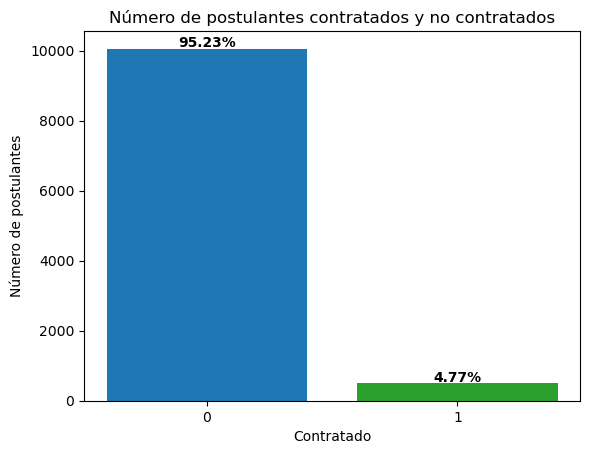

0    10058
1     2514
Name: contratado, dtype: int64


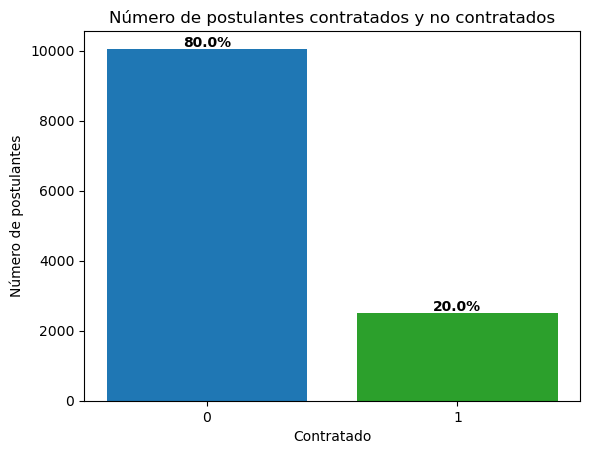

,column,differentValuesNumber
1,nombrePerfilConvocatoria,100
2,paisResidencia,14
3,empresaUltimoTrabajo,4229
4,paisUltimoTrabajo,31
5,areaUltimoTrabajo,152
6,nombreUltimoTrabajo,3154
7,institucionUltimoEstudio,1006
8,paisUltimoEstudio,30
9,areaUltimoEstudio,105
10,nombreUltimoEstudio,2478


,column,minValue,maxValue
1,sueldoPretendido,1.0,14600.0
2,diasUltimoTrabajo,5.0,2619.0
3,aniosExperiencia,0.1,32.9
4,numeroTrabajos,1.0,20.0
5,diasUltimoEstudio,1.0,6653.5
6,estadoUltimoEstudio,0.0,2.0
7,gradoUltimoEstudio,0.0,6.0
8,aniosEstudio,0.1,21.0
9,numeroEstudios,1.0,13.0
10,habilidadesTecnicas,1.0,35.0


11312
0.025218651376343472
1111
0.7668014422107575
1001
Obteniendo la data original
Obteniendo lista de métricas del modelado
Algoritmo con mayor promedio de métricas: Bosque aleatorio
Evaluando el modelo
Ejecutando para: Iteración 1 - Técnica K pliegues - Partición 1
Ejecutando para: Iteración 1 - Técnica K pliegues - Partición 2
Ejecutando para: Iteración 1 - Técnica K pliegues - Partición 3
Ejecutando para: Iteración 1 - Técnica K pliegues - Partición 4
Ejecutando para: Iteración 1 - Técnica K pliegues estratificados - Partición 1
Ejecutando para: Iteración 1 - Técnica K pliegues estratificados - Partición 2
Ejecutando para: Iteración 1 - Técnica K pliegues estratificados - Partición 3
Ejecutando para: Iteración 1 - Técnica K pliegues estratificados - Partición 4
Ejecutando para: Iteración 1 - Técnica División aleatoria - Partición 1
Ejecutando para: Iteración 1 - Técnica División aleatoria - Partición 2
Ejecutando para: Iteración 1 - Técnica División aleatoria - Partición 3
Ejecuta

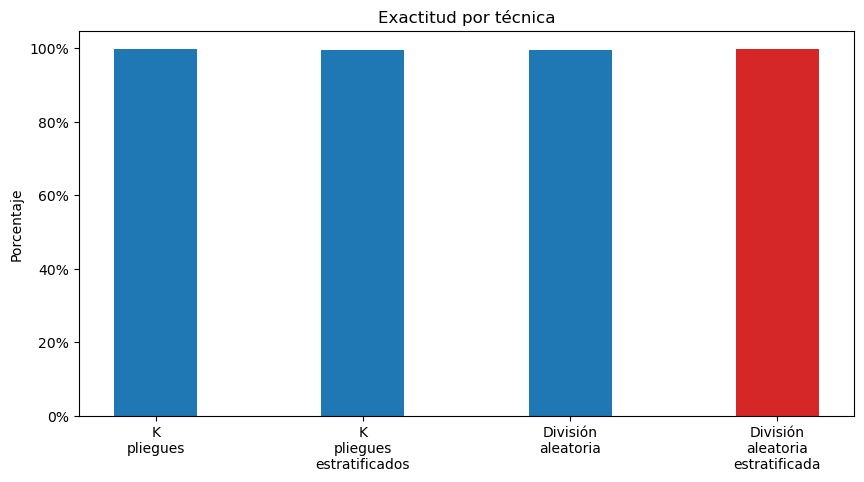

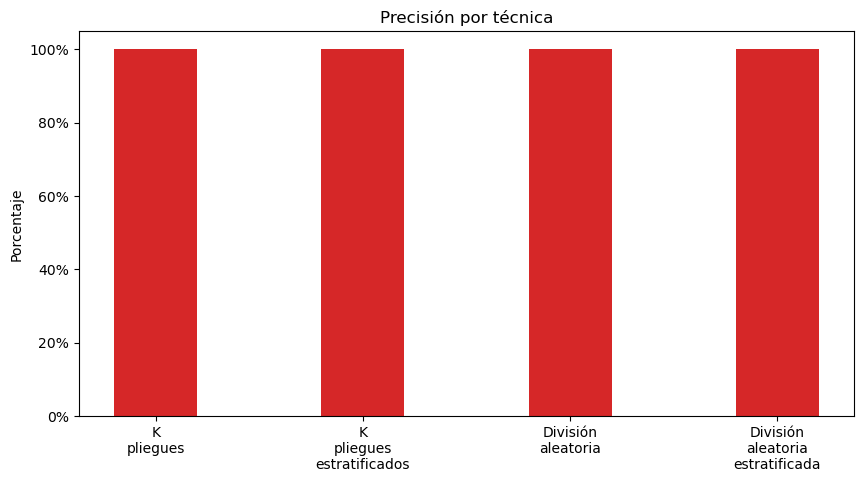

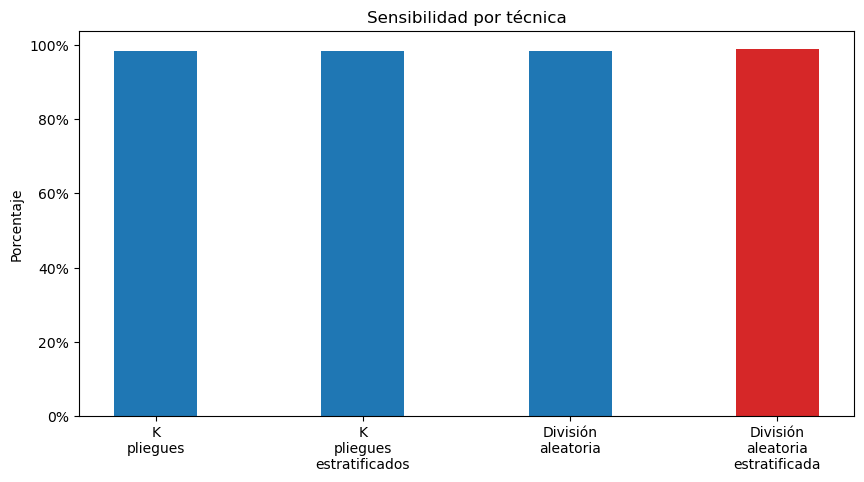

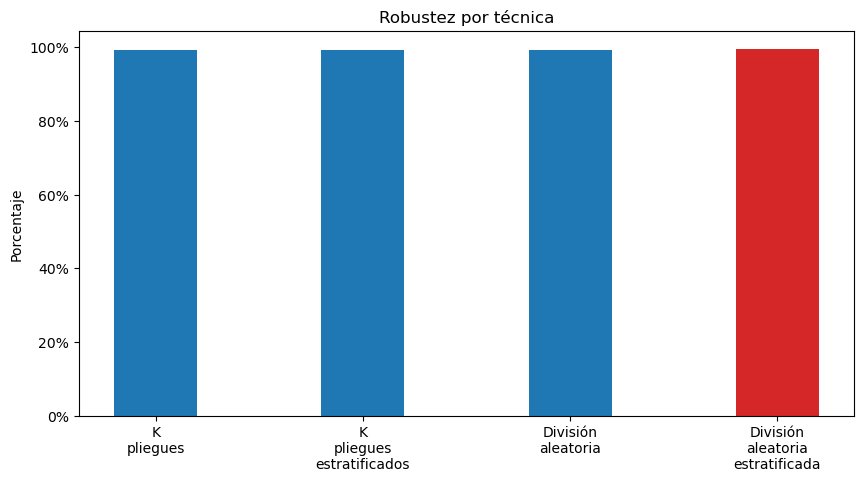

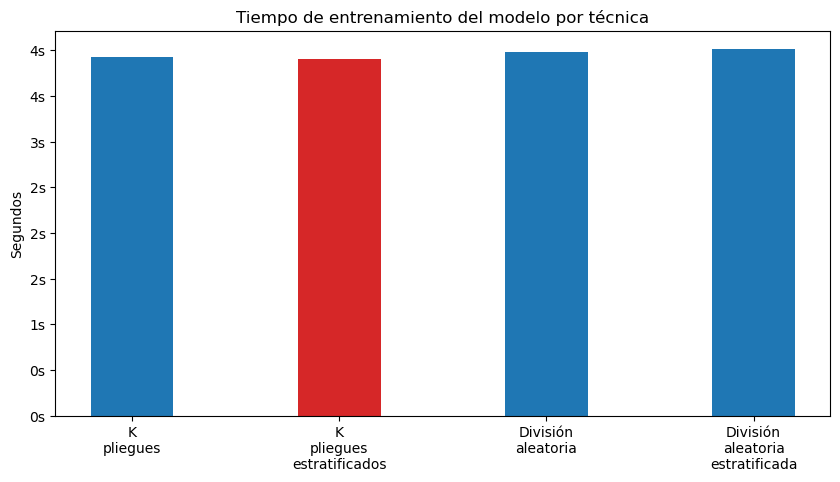

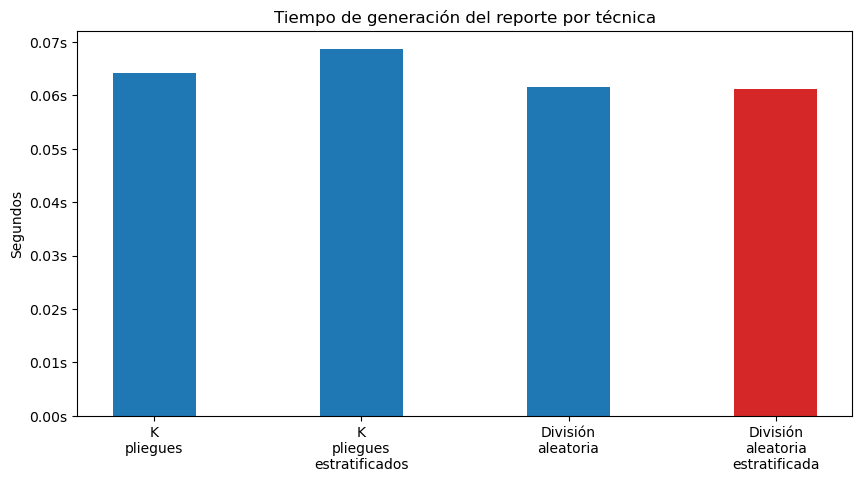

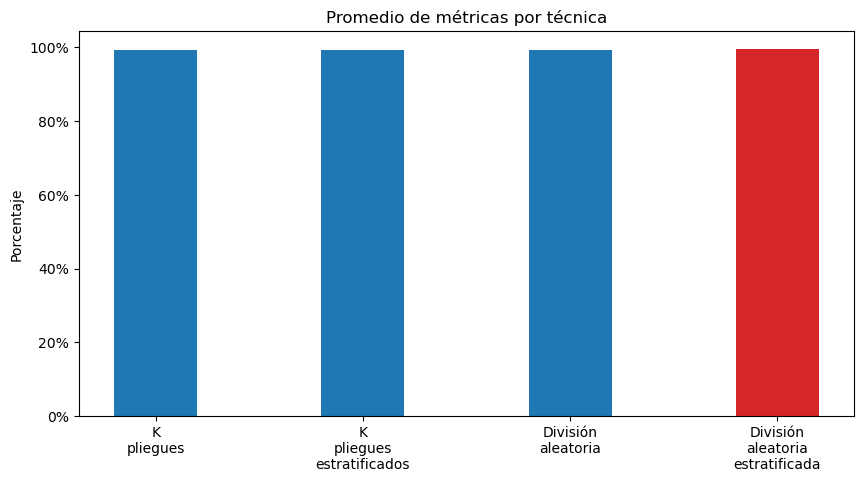

Técnica con mayor promedio de métricas: División aleatoria estratificada
Exactitud: 99.78%
Precisión: 100.00%
Sensibilidad: 98.90%
Robustez: 99.45%
Tiempo de entrenamiento del modelo: 4.17s
Tiempo de generación del reporte: 0.0617s
Promedio de métricas: 99.53%

Fin: 2023-07-25 00:12:25.354482
Tiempo: 0:03:45.182601


In [85]:
if __name__ == "__main__":
  main()